In [ ]:
!pip install openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.1/85.1 kB 47.3 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 262.9/262.9 kB 721.6 kB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 394.9/394.9 kB 965.9 kB/s eta 0:00:000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 1.6 MB/s eta 0:00:0000:0100:01


In [ ]:
import pandas as pd
import openai
import os

client = openai.OpenAI(api_key=os.environ.get("OPENAI_API_KEY", "Your key here"))



## Data Preparation


In [ ]:
from datasets import load_dataset, Dataset
import os

In [ ]:
dataset="burkelibbey/colors"


In [ ]:
def prepare_train_data(data_id):
    data = load_dataset(data_id, split="train")
    data_df = data.to_pandas()
    data_df = data_df.rename(columns={"description": "prompt", "color": "completion"})
    #data_df["text"] = data_df[["description", "color"]].apply(lambda x: "<|im_start|>user\n" + x["description"] + " <|im_end|>\n<|im_start|>assistant\n" + x["color"] + "<|im_end|>\n", axis=1)
    #data = Dataset.from_pandas(data_df)
    return data_df

In [ ]:
df = prepare_train_data(dataset)


In [ ]:
import numpy as np
train, validate = np.split(df.sample(frac=1, random_state=42), [int(.8*len(df))])

/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [ ]:
validate

,completion,prompt
7977,#404050,"Deep dusky blue: A subdued, mixed shade akin t..."
11463,#558080,Medium sea green: This color resembles the cal...
2035,#10dd66,Medium bright green: A vibrant and refreshing ...
20423,#99b0bb,Light powder blue: A soothing and gentle tone ...
10450,#5088d0,Medium blue: This is a moderate shade of blue ...
...,...,...
16850,#806680,"Muted purple: A subdued hue of purple, with un..."
6265,#30bb55,"Medium green: A vibrant, medium shade of green..."
11284,#55526f,"Dusky Blue-Purple: This color is a subdued, da..."
860,#00e0c0,"Turquoise Green: A vibrant, medium-light shade..."


In [ ]:
train.to_json("sport2_train.jsonl", orient='records', lines=True)
validate.to_json("sport2_validate.jsonl", orient='records', lines=True)

### Data Preparation tool
We can now use a data preparation tool which will suggest a few improvements to our dataset before fine-tuning. Before launching the tool we update the openai library to ensure we're using the latest data preparation tool. We additionally specify `-q` which auto-accepts all suggestions.

In [ ]:
!openai tools fine_tunes.prepare_data -f sport2_train.jsonl -q

Analyzing...

- Your file contains 27109 prompt-completion pairs
- There are 1 duplicated prompt-completion sets. These are rows: [17809]
- Your data does not contain a common separator at the end of your prompts. Having a separator string appended to the end of the prompt makes it clearer to the fine-tuned model where the completion should begin. See https://platform.openai.com/docs/guides/fine-tuning/preparing-your-dataset for more detail and examples. If you intend to do open-ended generation, then you should leave the prompts empty
- Your data does not contain a common ending at the end of your completions. Having a common ending string appended to the end of the completion makes it clearer to the fine-tuned model where the completion should end. See https://platform.openai.com/docs/guides/fine-tuning/preparing-your-dataset for more detail and examples.
- The completion should start with a whitespace character (` `). This tends to produce better results due to the tokenization we u

In [ ]:
!openai tools fine_tunes.prepare_data -f sport2_validate.jsonl -q

Analyzing...

- Your file contains 6778 prompt-completion pairs
- All prompts end with suffix `.`
- Your data does not contain a common ending at the end of your completions. Having a common ending string appended to the end of the completion makes it clearer to the fine-tuned model where the completion should end. See https://platform.openai.com/docs/guides/fine-tuning/preparing-your-dataset for more detail and examples.
- The completion should start with a whitespace character (` `). This tends to produce better results due to the tokenization we use. See https://platform.openai.com/docs/guides/fine-tuning/preparing-your-dataset for more details

Based on the analysis we will perform the following actions:
- [Recommended] Add a suffix ending `\n` to all completions [Y/n]: Y
- [Recommended] Add a whitespace character to the beginning of the completion [Y/n]: Y


Your data will be written to a new JSONL file. Proceed [Y/n]: Y

Wrote modified file to `sport2_validate_prepared (1).jsonl`

## Fine-tuning
The tool suggests we run the following command to train the dataset. Since this is a classification task, we would like to know what the generalization performance on the provided validation set is for our classification use case.

We can simply copy the suggested command from the CLI tool. We specifically add `-m ada` to fine-tune a cheaper and faster ada model, which is usually comperable in performance to slower and more expensive models on classification use cases.

In [ ]:
train_file = client.files.create(file=open("sport2_train_prepared.jsonl", "rb"), purpose="fine-tune")
valid_file = client.files.create(file=open("sport2_validate_prepared.jsonl", "rb"), purpose="fine-tune")

fine_tuning_job = client.fine_tuning.jobs.create(training_file=train_file.id, validation_file=valid_file.id, model="babbage-002")
#fine_tuning_job = client.fine_tuning.jobs.create(training_file=train_file.id, model="babbage-002")

print(fine_tuning_job)

FineTuningJob(id='ftjob-IoNcKkz8b0l6Yo2FX9hSJUu3', created_at=1711687264, error=Error(code=None, message=None, param=None, error=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs='auto', batch_size='auto', learning_rate_multiplier='auto'), model='babbage-002', object='fine_tuning.job', organization_id='org-UrCFrAQgfMUb8ZiERmPwF70D', result_files=[], status='validating_files', trained_tokens=None, training_file='file-Ww0T2rzi8Eq35dBW6kObTAPI', validation_file='file-mfeq2DI64aub29HWmtGupxNW', user_provided_suffix=None)


The model is successfully trained in about ten minutes. You can watch the finetune happen on [https://platform.openai.com/finetune/](https://platform.openai.com/finetune/)

You can also check on its status programatically:

In [ ]:
fine_tune_results = client.fine_tuning.jobs.retrieve('ftjob-IoNcKkz8b0l6Yo2FX9hSJUu3')
print(fine_tune_results.finished_at)

1711689428


### [Advanced] Results and expected model performance
We can now download the results file to observe the expected performance on a held out validation set.

In [ ]:
fine_tune_results = client.fine_tuning.jobs.retrieve('ftjob-IoNcKkz8b0l6Yo2FX9hSJUu3').result_files
result_file = client.files.retrieve(fine_tune_results[0])
content = client.files.content(result_file.id)
# save content to file
with open("result.csv", "wb") as f:
    f.write(content.text.encode("utf-8"))

In [ ]:
results = pd.read_csv('result.csv')
results[results['train_accuracy'].notnull()].tail(1)

,step,train_loss,train_accuracy,valid_loss,valid_mean_token_accuracy
1505,1506,2.06994,0.50575,NaN,NaN


The accuracy reaches 99.6%. On the plot below we can see how accuracy on the validation set increases during the training run.

<Axes: >

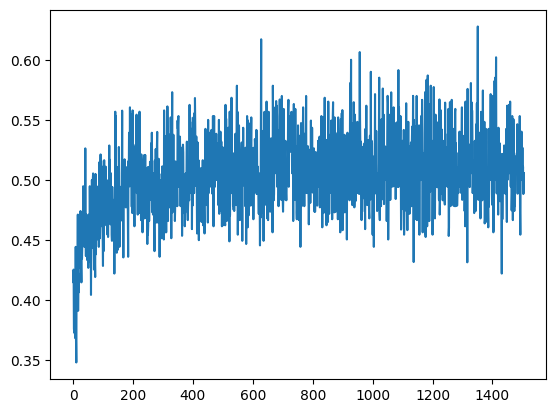

In [ ]:
results[results['train_accuracy'].notnull()]['train_accuracy'].plot()

## Using the model
We can now call the model to get the predictions.

We need to use the same separator following the prompt which we used during fine-tuning. In this case it is `\n\n###\n\n`. Since we're concerned with classification, we want the temperature to be as low as possible, and we only require one token completion to determine the prediction of the model.

In [ ]:
res = client.completions.create(model='ft:babbage-002:personal::97ytxXzy', prompt='light orange color' + '\n\n###\n\n', max_tokens=10, temperature=0)
res.choices


[CompletionChoice(finish_reason='length', index=0, logprobs=None, text=' #d0a0a0\n#ee')]